# Fit spatiotemporal receptive fields for remapping dataset with pyglmnet

## Imports

In [1]:
import numpy as np
from pyglmnet import GLM
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.io import loadmat, savemat 
import pandas as pd


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Read data file

In [2]:
df = pd.read_csv('probe_m15_d1v1_c21.csv')
df.head()

,probeNum,saccNum,numSaccs,trialNum,rawTrialNum,rewardedSacc,fixProbe,saccProbe,saccPeakVel,expectedPeakVel,...,x_probe,x_curFix,x_oneFixAhead,x_twoFixAhead,y_probe,y_curFix,y_oneFixAhead,y_twoFixAhead,units,unitsSC
0,1,1,5,1,1,0,1,0,444.253052,422.021942,...,9.071317,0.903307,-10.610318,14.089684,2.826060,0.179365,4.683333,13.083333,-209.175361,0
1,2,1,5,1,1,0,1,0,444.253052,422.021942,...,15.150524,0.903307,-10.610318,14.089684,-2.915777,0.179365,4.683333,13.083333,17.209209,0
2,3,1,5,1,1,0,1,0,444.253052,422.021942,...,15.150524,0.903307,-10.610318,14.089684,14.309735,0.179365,4.683333,13.083333,7.902643,0
3,4,2,5,1,1,0,1,0,865.433105,875.482239,...,21.229731,-10.960483,14.089684,16.423018,8.567898,4.078271,13.083333,16.583334,75.999679,1
4,5,2,5,1,1,0,1,0,865.433105,875.482239,...,21.229731,-10.960483,14.089684,16.423018,-14.399451,4.078271,13.083333,16.583334,38.652826,0


## define workspace

In [3]:
# define workspace 
N=6 # number of spatial basis functions in each dimension
n_basis = N*N
n_shape = 50 # width and height of workspace, in degrees

## Register probe x and y to current and next fixation

In [4]:
df['fix1_x'] = df.x_probe - df.x_oneFixAhead
df['fix1_y'] = df.y_probe - df.y_oneFixAhead

# now make sure that these probes fall within the spatial workspace
df['within_workspace']=(df.fix1_x>-n_shape/2) & (df.fix1_x<n_shape/2) & (df.fix1_y>-n_shape/2) & (df.fix1_y<n_shape/2)

## create some functions

In [5]:
def get_time_bins(df_of_latency, list_of_bins):
    all_time_bins_list = list()
    for i in df_of_latency.index:
        time_bin_list = list()
        for bin_id, bin_edges in enumerate(list_of_bins):
            if df_of_latency.loc[i] >= bin_edges[0] and \
               df_of_latency.loc[i] <= bin_edges[1]: 
                time_bin_list.append(bin_id)
        all_time_bins_list.append(time_bin_list)
    return all_time_bins_list

In [6]:
def design_prior_covariance_for_strf(n_t=8, n_s=25, sigma_t=10., sigma_s=10.):
    """
    Design a prior covariance matrix for STRF estimation
    """
    n_features = n_t * n_s    
    spatialCov = np.zeros([n_features, n_features])
    temporalCov = np.zeros([n_features, n_features])
    PriorCov = np.zeros([n_features, n_features])
    for i in np.arange(0, n_features):
        # Get spatiotemporal indices
        t_i = np.floor(np.float(i) / n_s)
        s_i = i % n_s
        # Convert spatial indices to (x,y) coordinates
        x_i, y_i = s_i % np.sqrt(n_s), np.floor(np.float(s_i) / np.sqrt(n_s))
        
        for j in np.arange(i, n_features):
            # Get spatiotemporal indices
            t_j = np.floor(np.float(j) / n_s)
            s_j = j % n_s
            # Convert spatial indices to (x,y) coordinates
            x_j, y_j = s_j % np.sqrt(n_s), np.floor(np.float(s_i) / np.sqrt(n_s))
        
            
            spatialCov[i, j] = np.exp(-1. / (sigma_s ** 2) * ((x_i - x_j) ** 2 + (y_i - y_j) ** 2))
            spatialCov[j, i] = spatialCov[i, j]
            temporalCov[i, j] = np.exp(-1. / (sigma_t ** 2) * (t_i - t_j) ** 2)
            temporalCov[j, i] = temporalCov[i, j]

            #if i == j:
            #    spatialCov[i, j] += 0.05
            #    temporalCov[i, j] += 0.05

    PriorCov = spatialCov * temporalCov
    PriorCov = 1./ np.max(PriorCov) * PriorCov
    return PriorCov, spatialCov, temporalCov


# USAGE
# C = design_prior_covariance_for_strf(n_t=8, n_s=25, sigma_t=10., sigma_s=10.)
# plt.figure(figsize=(10,10))
# plt.imshow(C, cmap='Greys')
# plt.colorbar()
# plt.show()

In [7]:
def make_gauss2D(shape=(3,3), sigma=0.5, center=(0,0)):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m : m + 1, -n : n + 1]
    y0, x0 = center[1], center[0]
    G = np.exp( -((x - x0) ** 2 + (y - y0) ** 2) / (2. * sigma ** 2) )
    G[G < np.finfo(G.dtype).eps * G.max()] = 0
    return 1. / G.max() * G

In [8]:
def make_spatial_basis(shape=(50,50), sigma=5, n_basis=25):
    """
    Makes a list of Gaussian filters
    
    Parameters
    ----------
    shape: tuple, 
        specifies the image size in pixels
        (should be the same)
    sigma: float,
        specifies the sigma of the Gaussian kernel
    n_basis: int,
        number of basis fuctions
        (has to be a perfect square)
    """
    Basis = list()
    
    n_tiles = np.sqrt(n_basis)
    n_pixels = shape[0]
    centers = np.linspace(start = -n_pixels / 2. + n_pixels / (n_tiles + 1.), 
                          stop = n_pixels / 2. - n_pixels / (n_tiles + 1.),
                          num=n_tiles)
    
    for y in np.arange(n_tiles):
        for x in np.arange(n_tiles):
            G = make_gauss2D(shape=shape, sigma=sigma, center=(centers[x], centers[y]))
            Basis.append(G)
    return Basis


# USAGE
# n_basis = 25
# n_tiles = np.sqrt(n_basis)
# Basis = make_spatial_basis((50,50), sigma=5, n_basis=n_basis)
# plt.figure(figsize=(7,7))
# for i in range(len(Basis)):
#     plt.subplot(np.int(n_tiles), np.int(n_tiles), i+1)
#     plt.imshow(Basis[i], cmap='Greys')
#     plt.axis('off')
# plt.show()

In [9]:
def project_to_basis(I, Basis):
    projection = np.zeros(len(Basis))
    for b in range(len(Basis)):
        projection[b] = np.sum(Basis[b] * I)
    return projection


# USAGE
# I = np.zeros((50,50))
# I[10, 12] = 1.
# vec25 = project_to_basis(I, Basis)
# plt.stem(vec25)
# plt.xlim([-1, 25])
# plt.show()

In [10]:
def make_RF_from_basis(Basis, weights):
    RF = np.zeros(Basis[0].shape)
    for b in range(len(Basis)):
        RF += weights[b] * Basis[b]
    return RF

In [11]:
import matplotlib.colors as mcolors

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

## Get probes within temporal window(s) of interest

In [12]:
# Define window params
lock_event = 't_sacc_start_lock'
sac_win_earliest = -75
sac_win_latest = 25
sac_win_size = 25
sac_win_inc = 25

# define start and end times for all windows
start_times = range(sac_win_earliest,sac_win_latest,sac_win_inc)
end_times = [x+sac_win_size for x in start_times]
list_of_bins = zip(start_times,end_times)

# now add the time bin variable
df['time_bin']= get_time_bins(df[lock_event], list_of_bins)



Note: Convert units_1 and units_2 to spike counts

## Build design matrix 

### Design spatial basis functions

In [13]:
Basis = make_spatial_basis(shape=(n_shape,n_shape), sigma=5, n_basis=n_basis)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Compute basis projections by looping through df

In [16]:
from tqdm import tqdm

n_timebins = len(list_of_bins)
X = [[] for x in xrange(n_timebins)]
Y = [[] for x in xrange(n_timebins)]

# Loop through probes
for probe_id in tqdm(df.index):
    
    # Check whether the probe lies within workspace and occured within time window of interest
    if df.loc[probe_id]['within_workspace'] == True &\
       len(df.loc[probe_id]['time_bin']) > 0:

        
        # Define an image based on the relative locations
        I = np.zeros(shape=(n_shape, n_shape))
        row = -np.round(df.loc[probe_id]['fix1_y']) + n_shape/2 - 1 
        col = np.round(df.loc[probe_id]['fix1_x']) + n_shape/2 - 1
        I[row, col] = 1
        
        # Compute projection
        basis_projection = project_to_basis(I, Basis)
        
        # Assign to probe features according to which time bins they were assigned
        for bin_ in df.loc[probe_id]['time_bin']:
            X[bin_].append(basis_projection)
            Y[bin_].append(df.loc[probe_id]['unitsSC'])

# X = np.array(X)
# Y = np.array(Y)  * 70.0 / 10000.0 #weird normalization

100%|██████████| 27586/27586 [00:29<00:00, 938.90it/s]


## Compute prior covariance matrix

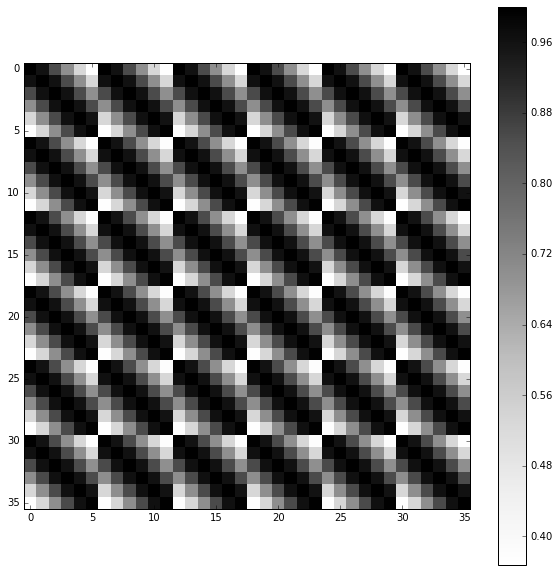

In [17]:
PriorCov, spatialCov, temporalCov = design_prior_covariance_for_strf(n_t=1, n_s=n_basis, 
                                                                     sigma_t=2., sigma_s=5.)
plt.figure(figsize=(10,10))
plt.imshow(PriorCov, cmap='Greys', interpolation='none')
#plt.imshow(spatialCov[0:25,0:25], cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()

## make colormap

In [ ]:
c = mcolors.ColorConverter().to_rgb
cmap2 = make_colormap(
    [c('black'), c('gray'), 0.75, c('white'), 0.85, c('yellow'), 0.95, c('red')])

In [30]:
cmap2(6)

(0.015747789311803151, 0.015747789311803151, 0.015747789311803151, 1.0)

## Fit Tikhonov regularized GLM

Time bin: 0
Xdata shape: (859, 36)
Ydata shape: (859,)
GLM score: 0.981066115433
Time bin: 1
Xdata shape: (781, 36)
Ydata shape: (781,)
GLM score: 0.976669845523
Time bin: 2
Xdata shape: (736, 36)
Ydata shape: (736,)
GLM score: 0.976122805293
Time bin: 3
Xdata shape: (1023, 36)
Ydata shape: (1023,)
GLM score: 0.960966584445


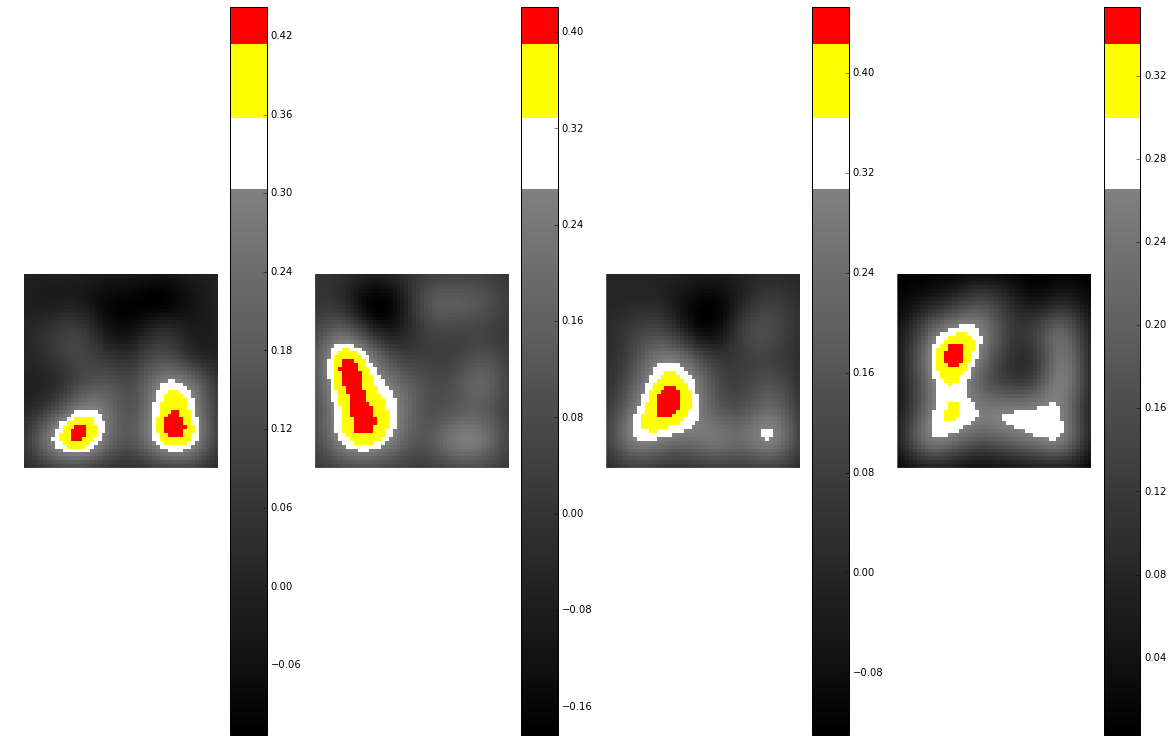

In [32]:
from pyglmnet import utils

# Tau = [[] for x in xrange(n_timebins)]
Tau = []

plt.figure(figsize=(20,14))
for bin2_ in range(n_timebins):

    # Correct non-zero elements
    Xn = np.array(X[bin2_])
    Yn = np.array(Y[bin2_])
    Xdata = Xn[Yn > 0., :]
    Ydata = Yn[Yn > 0.]
    
    print 'Time bin:',bin2_
    print 'Xdata shape:',Xdata.shape
    print 'Ydata shape:',Ydata.shape
    
    n_samples = Xdata.shape[0]
    Tau = utils.tikhonov_from_prior(PriorCov, n_samples)
    
    glm = GLM(distr='poisson', alpha=0., Tau=Tau, score_metric='pseudo_R2')
    glm.fit(Xdata, Ydata)

    Ydata_hat = glm[4].predict(Xdata)
    weights = glm[4].fit_['beta']
    
    print 'GLM score:',glm.score(Xdata, Ydata_hat)

    RF = make_RF_from_basis(Basis, weights)
    
    
    plt.subplot(1,n_timebins,bin2_+1)
    plt.imshow(RF, cmap=cmap2, interpolation='none')
    plt.axis('off')
    plt.colorbar()